# <font color = 'blue'> I.Data Preparation Part 1
<font color = 'blue'>The classification variable,"price_class", is a stratified log price of "Low", "Average", and "High", with threshold prices being defined based on property-type. The data will be scaled so that feature importance may be determined using class weights, and dimensionality reduction will be explored (PCA). In addition to this, several variables that are not thought to be important will be removed from the dataset.   In order to determine the most appropriate features to use, multiple datasets were explored in the modeling process. These include: the full dataset with numeric variables square-root transformed,  geographical location and property type attributes one-hot encoded, and a set of interaction terms between property type and log price; a reduced dataset with the same transformations and interations, but excluding the L3 department (county) attributes to improve computation time, and a third dataset using only the numeric variables.

In [17]:
# Import libraries
import numpy as np
import pandas as pd
from pandas import set_option
set_option('display.max_columns',400)
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import scipy


from sklearn.preprocessing import MinMaxScaler 
from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import normalize
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics as mt
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

In [2]:
# Read in the imputed dataset

# Tom
df = pd.read_csv('C:\\Users\\Tpeng\\OneDrive\\Documents\\SMU\\Term 3\\Machine Learning\\Lab1\\Imputed_Dataset.csv', sep = ',', header = 0)

#Quynh
#df = pd.read_csv('Imputed_Dataset.csv', sep = ',', header = 0)

# Anish
#df = pd.read_csv('filepath, sep = ',', header = 0)

# Michael
#df = pd.read_csv('filepath', sep = ',', header = 0)

# Drop index column
df = df.drop(columns = 'Unnamed: 0')

In [3]:
# Reformat attributes, excluding categoricals, which aren't supported for the the dummy variable generation method used.
ordinal_vars = ['rooms', 'bedrooms', 'bathrooms' ]
continuous_vars = ['lat', 'lon', 'surface_total', 'surface_covered', 'price', 'log_price']
string_vars = ['id', 'title', 'description']
time_vars = ['start_date', 'end_date', 'created_on']

# Change data types
df[ordinal_vars] = df[ordinal_vars].astype('uint8')
df[continuous_vars] = df[continuous_vars].astype(np.float64)
df[string_vars] = df[string_vars].astype(str)

# Remove observations missing l3 and price before encoding 
df2 = df.dropna(axis = 0, subset = ['price', 'l3'])

# Create dataset using numeric attributes only, make classification variable ordinal
df_num = df.copy()
df_num.loc[(df_num['price_class'] == 'Low'), 'price_class_final'] = 0
df_num.loc[(df_num['price_class'] == 'Average'), 'price_class_final'] = 1
df_num.loc[(df_num['price_class'] == 'High'), 'price_class_final'] = 2

df_num = df_num[['rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered', 'price', 'log_price', 'price_class_final']]
df_num = df_num.dropna()


Create a transformed dataset with numeric variables square-root transformed to better meet model assumptions of feature distributions. This reduces the number and magnitude of outliers. In addition to this, both datasets will have the property_type, country, province, and department dummified, and all other attributes will be scaled. Both the transformed and non-transformed datasets will be used to create competing models.

In [4]:
# Create datasets with transformed variables for model selection methods
# Transform rooms, bedrooms, bathrooms, surface_total, and surface_covered using square root
df_transform = df2.copy()
df_transform['sqrt_surface_total'] = df_transform.surface_total.transform(func = 'sqrt')
df_transform['sqrt_surface_covered'] = df_transform.surface_covered.transform(func = 'sqrt')
df_transform['sqrt_bedrooms'] = df_transform.bedrooms.transform(func = 'sqrt')
df_transform['sqrt_bathrooms'] = df_transform.bathrooms.transform(func = 'sqrt')
df_transform['sqrt_rooms'] = df_transform.rooms.transform(func = 'sqrt')

df_transform = df_transform.drop(columns = ['surface_total', 'surface_covered', 'bedrooms', 'bathrooms', 'rooms'])

In [6]:
# Get dummy variables for non-transformed dataset
data = pd.get_dummies(df2, columns = ['l1', 'l2', 'l3', 'property_type'], 
                      prefix = {'l1':'Country', 'l2':'Province', 'l3': 'Department', 'property_type': 'Property_type'}, 
                      sparse = True, drop_first = False)

# Drop reference levels for each dummified feature and unimportant or currently unusable features. 
data = data.drop(columns = ['Country_Argentina', 'Province_Misiones', 'Department_Posadas', 'Property_type_Casa'])
data = data.drop(columns = ['id', 'start_date', 'end_date', 'created_on', 'lat', 'lon', 'title', 'description', 'price'])

# Get dummy variables for transformed dataset
trans = pd.get_dummies(df_transform, columns = ['l1', 'l2', 'l3', 'property_type'], 
                          prefix = {'l1':'Country', 'l2':'Province', 'l3': 'Department', 'property_type': 'Property_type'}, 
                          sparse = True, drop_first = False)

# Drop reference levels for each dummified feature (same references as non-transformed data) and unimportant or currently unusable features. 
trans = trans.drop(columns = ['Country_Argentina', 'Province_Misiones', 'Department_Posadas', 'Property_type_Casa'])
trans = trans.drop(columns = ['id', 'start_date', 'end_date', 'created_on', 'lat', 'lon', 'title', 'description', 'price'])

# <font color ='blue'>II.Data Preparation Part 2
<font color = 'blue'> The final data set has 441,216 rows with 1,214 features considered relevant to the classification of price categories: Low, Average, High and also to price predictions. Numerical features include:  

<font color = 'blue'>price   

<font color = 'blue'>surface_total  

<font color = 'blue'>surface_covered

<font color = 'blue'>bedrooms        

<font color = 'blue'>bathrooms       

<font color = 'blue'>In addition dummy variables for country types, region types and property types were created for purposes of building our models.  

</font> <font color = 'blue'>Models were trained using each dataset described above, and the results of this analysis indicated that the numeric dataset performed far better than the other two datasets (accuracy of ~92% vs ~60%).  The final dataset used was the numeric feature dataset. For classification tasks, the target variable will be price classification and the data are rooms counts, property areas, price, and log price.  For regression tasks the target will be log price and the data are room counts and property areas.


In [23]:
X=trans.drop(['price_class'], axis =1)
X=np.asarray(X)
y=np.asarray(trans['price_class'])
X.shape

(441216, 1214)

# <font color = 'blue'>III. Modeling and Evaluation 1: Evaluation Metrics
<font color = 'blue'>Evaluation metrics used to evaluate our models include F1 scores, accuracy, and precision for classification tasks, and MSE for regression tasks.  Since our dataset is to be used by investors to make decisions on how good a property is for investment from a price point perspective, it is important to be accurate.  It is also important for the model to have a high precision, which indicates how trustworthy the models predictions are.  Since customers are using the models to determine whether an individual property is under/over priced, it is more important that the model's prediction for an individual property is correct (precision) than the model correctly identifying the majority of a given price classification (recall).  For the classification tasks, F1 scores will be our first metric because it blends both accuracy and precision measures. Among those with the top F1 scores, we looked at accuracy as our next measure of importance because we have a balanced dataset.  For the price prediction tasks, MSE will be used to evaluate models.

# <font color = 'blue'>IV. Modeling and Evaluation 2: Train-Test Split Data
<font color = 'blue'>Stratified 5-fold cross validation was used to split the data into 80-20 train-test split before normalization to prevent the test set data from influencing the training data scale.  In addition, this cross validation will adjust for any imbalance features in the data set including the overrepresentations or underrepresentations of properties by country, and regional differences like province, department.  

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state = 6)

In [51]:
from sklearn.model_selection import StratifiedKFold
cv_obj = StratifiedKFold(n_splits = 5, random_state = 6)

C:\Users\Tpeng\AppData\Roaming\Python\Python37\site-packages\sklearn\model_selection\_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


## IV.Modeling and Evaluation 3
Two tasks were carried out using the transformed data set containing numerical features:
1. Classification of Properties into price categories : Low, Average, High  using 3 models- KNN, Randomforest Classifier, and ExtraTrees Classifier
2. Prediction of Property Prices: price prediction using KNN regression, Randomforest regression and XXXXXX

Model selection and hyperparameter tuning were done using a combination of AutoML (TPOT) and grid searches.  TPOT was run to find the best models and parameters, which were then selected based on accuracy and F1 scores, or MSE. The tuning of selected models' hyperparameters were carried out using GridSearchCV to find the optimal parameters for both classification and prediction tasks. 

In [33]:
# Run TPOT Code for model selection
from tpot import TPOTClassifier
#from tpot import TPOTRegression

# Split data into features and target
X = df_num.drop('price_class_final', axis = 1).values
y = df_num.price_class_final.values

# Normalize features
X = preprocessing.normalize(X, norm = 'max', axis = 0, copy = False)

# Split the data using 80-20 split for initial TPOT model/grid search
X_train, X_test, y_train, y_test = train_test_split(X.astype(np.float64),
    y.astype(np.float64), train_size=0.8, test_size=0.2, random_state=6)

In [35]:
X[0]

array([1.00000000e-01, 2.70270270e-02, 1.00000000e-01, 3.96000000e-04,
       1.64703945e-06, 8.04186068e-03, 7.27263667e-01])

In [6]:
# Run TPOT Classifier
tpot = TPOTClassifier(generations = 2, population_size = 20, verbosity = 1, n_jobs = -1, random_state = 6)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))
tpot.export('tpot_pipeline.py')

Best pipeline: RandomForestClassifier(input_matrix, bootstrap=True, criterion=entropy, max_features=0.15000000000000002, min_samples_leaf=12, min_samples_split=3, n_estimators=100)
0.9293654644455227


In [8]:
# Run TPOT Classifier
tpot = TPOTClassifier(generations = 2, population_size = 20, verbosity = 3, n_jobs = -1, random_state = 6)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))
tpot.export('tpot_pipeline2.py')


32 operators have been imported by TPOT.


Skipped pipeline #3 due to time out. Continuing to the next pipeline.
Skipped pipeline #5 due to time out. Continuing to the next pipeline.
Skipped pipeline #7 due to time out. Continuing to the next pipeline.
Skipped pipeline #14 due to time out. Continuing to the next pipeline.
Skipped pipeline #17 due to time out. Continuing to the next pipeline.
Skipped pipeline #22 due to time out. Continuing to the next pipeline.
Skipped pipeline #26 due to time out. Continuing to the next pipeline.
Skipped pipeline #29 due to time out. Continuing to the next pipeline.
Skipped pipeline #31 due to time out. Continuing to the next pipeline.
Skipped pipeline #33 due to time out. Continuing to the next pipeline.
Skipped pipeline #35 due to time out. Continuing to the next pipeline.
Skipped pipeline #39 due to time out. Continuing to the next pipeline.
Skipped pipeline #41 due to time out. Continuing to the next pipeline.
Skipped pipeline #45 due to time out. Continuing to the next pipeline.
Skipped p

In [12]:
tpot.evaluated_individuals_

{'MLPClassifier(input_matrix, MLPClassifier__alpha=0.1, MLPClassifier__learning_rate_init=1.0)': {'generation': 0,
  'mutation_count': 0,
  'crossover_count': 0,
  'predecessor': ('ROOT',),
  'operator_count': 1,
  'internal_cv_score': 0.3336370846209284},
 'ExtraTreesClassifier(input_matrix, ExtraTreesClassifier__bootstrap=False, ExtraTreesClassifier__criterion=entropy, ExtraTreesClassifier__max_features=0.1, ExtraTreesClassifier__min_samples_leaf=3, ExtraTreesClassifier__min_samples_split=10, ExtraTreesClassifier__n_estimators=100)': {'generation': 0,
  'mutation_count': 0,
  'crossover_count': 0,
  'predecessor': ('ROOT',),
  'operator_count': 1,
  'internal_cv_score': 0.5679232252692458},
 'MLPClassifier(RobustScaler(input_matrix), MLPClassifier__alpha=0.01, MLPClassifier__learning_rate_init=0.001)': {'generation': 0,
  'mutation_count': 0,
  'crossover_count': 0,
  'predecessor': ('ROOT',),
  'operator_count': 2,
  'internal_cv_score': -inf},
 'LinearSVC(MultinomialNB(input_matrix

In [37]:
# Run TPOT Classifier with 3-fold CV to save time
tpot = TPOTClassifier(generations = 3, population_size = 25, verbosity = 3, n_jobs = -1, random_state = 6, cv = 3)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))
tpot.export('tpot_pipeline3.py')

32 operators have been imported by TPOT.


Skipped pipeline #5 due to time out. Continuing to the next pipeline.
Skipped pipeline #13 due to time out. Continuing to the next pipeline.
Skipped pipeline #20 due to time out. Continuing to the next pipeline.
Skipped pipeline #24 due to time out. Continuing to the next pipeline.
Skipped pipeline #28 due to time out. Continuing to the next pipeline.
_pre_test decorator: _random_mutation_operator: num_test=0 Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty..
_pre_test decorator: _random_mutation_operator: num_test=0 Unsupported set of arguments: The combination of penalty='l2' and loss='hinge' are not supported when dual=False, Parameters: penalty='l2', loss='hinge', dual=False.
_pre_test decorator: _random_mutation_operator: num_test=0 No feature in X meets the variance threshold 0.10000.
Pipeline encountered that has previously been evaluated during the optimization process. Using the score from the previous evaluation.
Skipped pipeline #34 due to time out. Contin

TPOT suggests that the most appropriate model is a Random Forest Classifier.

## KNN Classification
The following stratified 5-fold cross-validated model uses KNN classifier on our numeric dataset. A grid search is conducted over a range of k-values and weighting parameters to determine the optimum model parameters. These will then be used to train our final KNN model which will be explored further below.

In [43]:
# Create a grid search object to optimize KNN parameter values
clf_pipe = Pipeline([('Scaler', MinMaxScaler(copy = False)),
                     ('KNN', KNeighborsClassifier(n_jobs = -1))])

params = dict(KNN__n_neighbors = [21, 31, 41, 51, 55, 57, 61, 65],
             KNN__weights = ['uniform', 'distance'])
grid = GridSearchCV(clf_pipe, param_grid = params, cv = 5, n_jobs = -1, verbose = 2, scoring = 'accuracy')

%time grid.fit(X,y)
print('The optimum parameters were: ', grid.best_params_, '\n')
print('The best estimator was: ', grid.best_estimator_, '\n')
print('With an accuracy of: ', grid.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  58 out of  80 | elapsed: 33.1min remaining: 12.5min
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed: 39.0min finished


Wall time: 41min 56s
The optimum parameters were:  {'KNN__n_neighbors': 21, 'KNN__weights': 'distance'} 

The best estimator was:  Pipeline(steps=[('Scaler', MinMaxScaler(copy=False)),
                ('KNN',
                 KNeighborsClassifier(n_jobs=-1, n_neighbors=21,
                                      weights='distance'))]) 

With an accuracy of:  0.8332881774081102


The final KNN model is trained below using the previously found optimum parameter values. Model performance will be visualized using a confusion matrix, and feature importance will be determined using.

In [47]:
# Final KNN model with cross-validation
it = 0

for train, test in cv_obj.split(X,y):
    print('######## CV SPLIT ', it, ' #######\n')
    clf_pipe = Pipeline([('Scaler', MinMaxScaler(copy = False)),
                        ('KNN', KNeighborsClassifier(n_neighbors = 21, weights = 'distance', n_jobs = -1))])
        
    %time clf_pipe.fit(X[train],y[train])
    %time yhat = clf_pipe.predict(X[test])
    total_acc = mt.accuracy_score(y[test],yhat)
    precision, recall, f_score, support = mt.precision_recall_fscore_support(y[test],yhat, 
                                                                            labels = [0, 1, 2])
        
    print(mt.confusion_matrix(y[test], yhat))
    print('KNN Accuracy: k = 21 ', total_acc)
    print('Precision: ', precision)
    print('Recall: ', recall)
    print('F Score: ', f_score, '\n')
    it += 1
    print('#############################\n')

######## CV SPLIT  0  #######

Wall time: 1min 8s
Wall time: 8.28 s
[[26379  3483   323]
 [ 1706 26168  2933]
 [  256  2772 28725]]
KNN Accuracy: k = 21  0.876295218071055
Precision:  [0.93077167 0.80708139 0.89818955]
Recall:  [0.87391088 0.84941734 0.90463893]
F Score:  [0.90144551 0.82770837 0.9014027 ] 

#############################

######## CV SPLIT  1  #######

Wall time: 1min 21s
Wall time: 5.52 s
[[26188  3556   441]
 [ 2006 25428  3374]
 [  377  2962 28413]]
KNN Accuracy: k = 21  0.8628928783222816
Precision:  [0.91659375 0.7959682  0.88162467]
Recall:  [0.86758324 0.82537003 0.89484127]
F Score:  [0.89141534 0.81040252 0.88818381] 

#############################

######## CV SPLIT  2  #######

Wall time: 1min 10s
Wall time: 6.04 s
[[26185  3639   361]
 [ 1918 25803  3087]
 [  336  2977 28439]]
KNN Accuracy: k = 21  0.8671842147824681
Precision:  [0.92074264 0.79592214 0.89186816]
Recall:  [0.86748385 0.8375422  0.89566012]
F Score:  [0.89332014 0.81620194 0.89376012] 

####

Below we define a function that allows us to plot the results of the KNN classifier using a multiclass confusion matrix. The model is run on a sample data split and the results are plotted below.

In [48]:
# Plot confusion matrix 
import seaborn as sns

# Function was from https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

######## CV SPLIT  0  #######

Wall time: 1min 47s
Wall time: 4.98 s


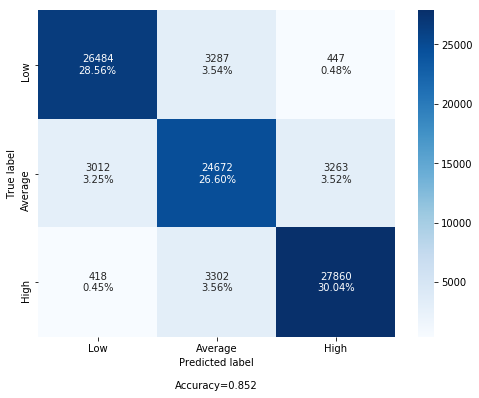

In [53]:
# Run model and output confusion matrix
from sklearn.model_selection import ShuffleSplit
cv_obj_viz = ShuffleSplit(n_splits = 1, test_size = .2, random_state = 6)

# Final KNN model with cross-validation
it = 0

for train, test in cv_obj_viz.split(X,y):
    print('######## CV SPLIT ', it, ' #######\n')
    clf_pipe = Pipeline([('Scaler', MinMaxScaler(copy = False)),
                        ('KNN', KNeighborsClassifier(n_neighbors = 21, weights = 'distance', n_jobs = -1))])
        
    %time clf_pipe.fit(X[train],y[train])
    %time yhat = clf_pipe.predict(X[test])
    total_acc = mt.accuracy_score(y[test],yhat)
    precision, recall, f_score, support = mt.precision_recall_fscore_support(y[test],yhat, 
                                                                            labels = [0, 1, 2])
        
    cf_matrix = mt.confusion_matrix(y[test], yhat)
    #print('KNN Accuracy: k = 21 ', total_acc)
    #print('Precision: ', precision)
    #print('Recall: ', recall)
    #print('F Score: ', f_score, '\n')
    #it += 1
    #print('#############################\n')

    categories = ['Low', 'Average', 'High']
    make_confusion_matrix(cf_matrix, figsize=(8,6), cbar=True, sum_stats=True, categories=categories )

In [54]:
# Must use GridSearchCV on final model to get fit times and performance metrics
clf_pipe = Pipeline([('Scaler', MinMaxScaler(copy = False)),
                     ('KNN', KNeighborsClassifier(n_jobs = -1))])

params = dict(KNN__n_neighbors = [21],
             KNN__weights = ['distance'])
grid = GridSearchCV(clf_pipe, param_grid = params, cv = 5, n_jobs = -1, verbose = 2, scoring = 'accuracy')

%time grid.fit(X,y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.2min remaining:  3.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.6min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.6min finished


Wall time: 5min 30s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', MinMaxScaler(copy=False)),
                                       ('KNN',
                                        KNeighborsClassifier(n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'KNN__n_neighbors': [21],
                         'KNN__weights': ['distance']},
             scoring='accuracy', verbose=2)

In [55]:
# Export model performance metrics to CSV file
cvres = pd.DataFrame(grid.cv_results_)
cvres.to_csv('KNNClassification_Results 1.csv', index = False)

## Random Forest Classification
The results of the TPOT analysis indicated that the best model for our dataset was random forest classifier with the following parameters: the gini coefficient as the classification criterion, max_features = .35, min_samples_leaf = 2, min_samples_split = 16, n_estimators = 100. This model will be built below.

In [57]:
# Must use GridSearchCV on final model to get fit times and performance metrics
clf_pipe = Pipeline([('Scaler', MinMaxScaler(copy = False)),
                     ('CLF', RandomForestClassifier(n_jobs = -1))])

params = dict(CLF__criterion = ['gini'],
              CLF__max_features = [.35],
              CLF__min_samples_leaf = [2],
              CLF__min_samples_split = [16],
              CLF__n_estimators = [100])

grid = GridSearchCV(clf_pipe, param_grid = params, cv = 5, n_jobs = -1, verbose = 2, scoring = 'accuracy')

%time grid.fit(X,y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   22.6s remaining:   34.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   22.8s finished


Wall time: 29.2 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', MinMaxScaler(copy=False)),
                                       ('CLF',
                                        RandomForestClassifier(n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'CLF__criterion': ['gini'],
                         'CLF__max_features': [0.35],
                         'CLF__min_samples_leaf': [2],
                         'CLF__min_samples_split': [16],
                         'CLF__n_estimators': [100]},
             scoring='accuracy', verbose=2)

In [58]:
# Export model performance metrics to CSV file
cvres = pd.DataFrame(grid.cv_results_)
cvres.to_csv('RFClassification_Results 1.csv', index = False)

######## CV SPLIT  0  #######

Wall time: 5.64 s
Wall time: 238 ms
Random Forest Accuracy:  0.9344331230794113
Precision:  [0.96472568 0.90608526 0.9335397 ]
Recall:  [0.94850751 0.8997318  0.9549715 ]
F Score:  [0.95654786 0.90289735 0.94413399] 

#############################



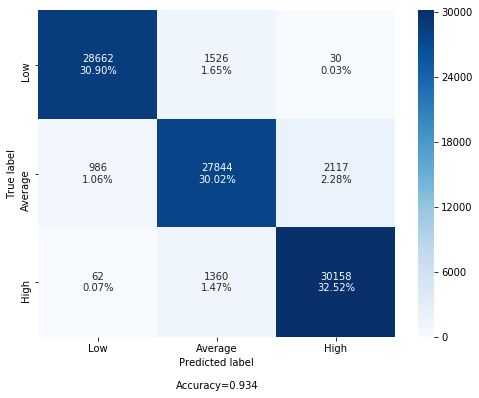

In [62]:
# Must use GridSearchCV on final model to get fit times and performance metrics
# Run model and output confusion matrix
from sklearn.model_selection import ShuffleSplit
cv_obj_viz = ShuffleSplit(n_splits = 1, test_size = .2, random_state = 6)

# Final KNN model with cross-validation
it = 0

for train, test in cv_obj_viz.split(X,y):
    print('######## CV SPLIT ', it, ' #######\n')
    clf_pipe = Pipeline([('Scaler', MinMaxScaler(copy = False)),
                     ('CLF', RandomForestClassifier(criterion = 'gini', max_features = .35, min_samples_leaf = 2,
                                                    min_samples_split = 16, n_estimators = 100, n_jobs = -1))])
        
    %time clf_pipe.fit(X[train],y[train])
    %time yhat = clf_pipe.predict(X[test])
    total_acc = mt.accuracy_score(y[test],yhat)
    precision, recall, f_score, support = mt.precision_recall_fscore_support(y[test],yhat, 
                                                                            labels = [0, 1, 2])
        
    cf_matrix = mt.confusion_matrix(y[test], yhat)
    print('Random Forest Accuracy: ', total_acc)
    print('Precision: ', precision)
    print('Recall: ', recall)
    print('F Score: ', f_score, '\n')
    #it += 1
    print('#############################\n')

    categories = ['Low', 'Average', 'High']
    make_confusion_matrix(cf_matrix, figsize=(8,6), cbar=True, sum_stats=True, categories=categories )

## Extra Trees Classifier
The TPOT analysis indicated that the extra trees classifier also performed very well on our numeric dataset, with an accuracy of ~90%. We will build an extra trees classifer using the optimum parameters found by TPOT.

In [60]:
from sklearn.ensemble import ExtraTreesClassifier

# Must use GridSearchCV on final model to get fit times and performance metrics
clf_pipe = Pipeline([('Scaler', MinMaxScaler(copy = False)),
                     ('CLF', ExtraTreesClassifier(n_jobs = -1))])

params = dict(CLF__criterion = ['gini'],
              CLF__max_features = [.85],
              CLF__min_samples_leaf = [17],
              CLF__min_samples_split = [19],
              CLF__n_estimators = [100])

grid = GridSearchCV(clf_pipe, param_grid = params, cv = 5, n_jobs = -1, verbose = 2, scoring = 'accuracy')

%time grid.fit(X,y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   30.3s remaining:   45.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   30.6s finished


Wall time: 37.3 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', MinMaxScaler(copy=False)),
                                       ('CLF',
                                        ExtraTreesClassifier(n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'CLF__criterion': ['gini'],
                         'CLF__max_features': [0.85],
                         'CLF__min_samples_leaf': [17],
                         'CLF__min_samples_split': [19],
                         'CLF__n_estimators': [100]},
             scoring='accuracy', verbose=2)

In [61]:
# Export model performance metrics to CSV file
cvres = pd.DataFrame(grid.cv_results_)
cvres.to_csv('ETCClassification_Results 1.csv', index = False)

######## CV SPLIT  0  #######

Wall time: 5.93 s
Wall time: 238 ms
Extra Trees Classification Accuracy:  0.9195320502452963
Precision:  [0.95766711 0.8820883  0.92056681]
Recall:  [0.93354954 0.88063463 0.94423686]
F Score:  [0.94545455 0.88136087 0.93225161] 

#############################



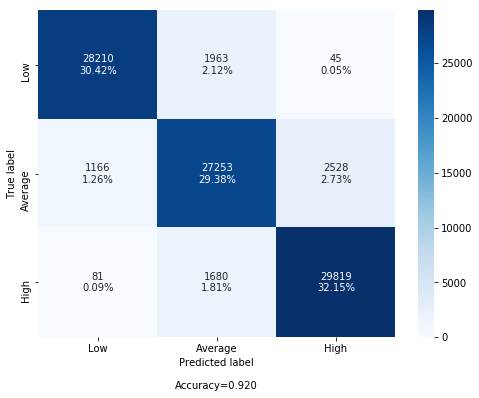

In [63]:
# Must use GridSearchCV on final model to get fit times and performance metrics
# Run model and output confusion matrix
from sklearn.model_selection import ShuffleSplit
cv_obj_viz = ShuffleSplit(n_splits = 1, test_size = .2, random_state = 6)

# Final KNN model with cross-validation
it = 0

for train, test in cv_obj_viz.split(X,y):
    print('######## CV SPLIT ', it, ' #######\n')
    clf_pipe = Pipeline([('Scaler', MinMaxScaler(copy = False)),
                     ('CLF', ExtraTreesClassifier(criterion = 'gini', max_features = .85, min_samples_leaf = 17,
                                                    min_samples_split = 19, n_estimators = 100, n_jobs = -1))])
        
    %time clf_pipe.fit(X[train],y[train])
    %time yhat = clf_pipe.predict(X[test])
    total_acc = mt.accuracy_score(y[test],yhat)
    precision, recall, f_score, support = mt.precision_recall_fscore_support(y[test],yhat, 
                                                                            labels = [0, 1, 2])
        
    cf_matrix = mt.confusion_matrix(y[test], yhat)
    print('Extra Trees Classification Accuracy: ', total_acc)
    print('Precision: ', precision)
    print('Recall: ', recall)
    print('F Score: ', f_score, '\n')
    #it += 1
    print('#############################\n')

    categories = ['Low', 'Average', 'High']
    make_confusion_matrix(cf_matrix, figsize=(8,6), cbar=True, sum_stats=True, categories=categories )

## <font color = 'blue'>Price Prediction using Regression Modeling
<font color = 'blue'>The second task of predicting price was done using TPOTRegressor to determine which type of regression model and related parameters perform best with our numerical data set.

In [65]:
# Create a new dataset for regression model to predict log_price
X = df_num.drop(columns = ['price_class_final', 'log_price', 'price'], axis = 1).values
y = df_num.log_price.values

# Split the data using 80-20 split for initial TPOT model/grid search
X_train, X_test, y_train, y_test = train_test_split(X.astype(np.float64),
    y.astype(np.float64), train_size=0.8, test_size=0.2, random_state=6)

In [67]:
from tpot import TPOTRegressor

# Run TPOT Regressor
tpot = TPOTRegressor(generations = 3, population_size = 25, verbosity = 3, n_jobs = -1, random_state = 6)
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))
tpot.export('tpot_reg_pipeline.py')

30 operators have been imported by TPOT.


Skipped pipeline #1 due to time out. Continuing to the next pipeline.
Skipped pipeline #6 due to time out. Continuing to the next pipeline.
Skipped pipeline #13 due to time out. Continuing to the next pipeline.
Skipped pipeline #32 due to time out. Continuing to the next pipeline.
Skipped pipeline #39 due to time out. Continuing to the next pipeline.

Generation 1 - Current Pareto front scores:
-1	-0.350570079073184	KNeighborsRegressor(input_matrix, KNeighborsRegressor__n_neighbors=75, KNeighborsRegressor__p=1, KNeighborsRegressor__weights=distance)
_pre_test decorator: _random_mutation_operator: num_test=0 cosine was provided as affinity. Ward can only work with euclidean distances..ootstrap=False, RandomForestRegressor__max_features=0.25, RandomForestRegressor__min_samples_leaf=5, RandomForestRegressor__min_samples_split=12, RandomForestRegressor__n_estimators=100)
Invalid pipeline encountered. Skipping its evaluation.

Generation 2 - Current Pareto front scores:
-1	-0.35057007907318

<font color = 'blue'>The TPOT Regressor analysis indicated that the both K-Neighbors and Random Forest regression models may be effective in predicting log price.  The recommended hyperparameters will be used to train our regression models.

## <font color = 'blue'>K-Neighbors Regression

In [72]:
# Using TPOT hyperparameters, train the model
from sklearn.neighbors import KNeighborsRegressor

# Must use GridSearchCV on final model to get fit times and performance metrics
reg_pipe = Pipeline([('Scaler', MinMaxScaler(copy = False)),
                     ('REG', KNeighborsRegressor(n_jobs = -1))])

params = dict(REG__n_neighbors = [75],
              REG__weights = ['distance'],
              REG__p = [1])

grid = GridSearchCV(reg_pipe, param_grid = params, cv = 5, n_jobs = -1, verbose = 2, scoring = 'neg_mean_squared_error')

%time grid.fit(X,y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.1min remaining:  3.2min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.5min finished


Wall time: 4min 53s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', MinMaxScaler(copy=False)),
                                       ('REG',
                                        KNeighborsRegressor(n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'REG__n_neighbors': [75], 'REG__p': [1],
                         'REG__weights': ['distance']},
             scoring='neg_mean_squared_error', verbose=2)

In [73]:
# Export model performance metrics to CSV file
cvres = pd.DataFrame(grid.cv_results_)
cvres.to_csv('KNNRegression_Results 1.csv', index = False)

In [78]:
# Run a KNeighborsRegressor in cv_obj loop to gather visualization data
cv_obj = ShuffleSplit(n_splits = 5, random_state = 6)



## <font color = 'blue'>Random Forest Regression
<font color = 'blue'>Using the TPOT recommended hyperparameters a random forest regression model will be trained on our data.

In [75]:
# Using TPOT hyperparameters, train the model
from sklearn.ensemble import RandomForestRegressor

# Must use GridSearchCV on final model to get fit times and performance metrics
reg_pipe = Pipeline([('Scaler', MinMaxScaler(copy = False)),
                     ('REG', RandomForestRegressor(n_jobs = -1))])

params = dict(REG__bootstrap = [False],
              REG__max_features = [0.25],
              REG__min_samples_leaf = [5],
              REG__min_samples_split = [12],
              REG__n_estimators = [100])

grid = GridSearchCV(reg_pipe, param_grid = params, cv = 5, n_jobs = -1, verbose = 2, scoring = 'neg_mean_squared_error')

%time grid.fit(X,y)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:   11.4s remaining:   17.2s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.8s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   11.8s finished


Wall time: 14.1 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Scaler', MinMaxScaler(copy=False)),
                                       ('REG',
                                        RandomForestRegressor(n_jobs=-1))]),
             n_jobs=-1,
             param_grid={'REG__bootstrap': [False], 'REG__max_features': [0.25],
                         'REG__min_samples_leaf': [5],
                         'REG__min_samples_split': [12],
                         'REG__n_estimators': [100]},
             scoring='neg_mean_squared_error', verbose=2)

In [76]:
# Export model performance metrics to CSV file
cvres = pd.DataFrame(grid.cv_results_)
cvres.to_csv('RFRegression_Results 1.csv', index = False)

In [ ]:
#######################################
# Can get feature_importances_, MSE
# Use CV Loop to gather visualization data
for train, test in cv_obj.split(X,y):
    

## Deep Learning Regression

In [5]:
# Create a new dataset for regression model to predict log_price
X = df_num.drop(columns = ['price_class_final', 'log_price', 'price'], axis = 1).values
y = df_num.log_price.values


In [9]:
# Regression: Standardized and Wider
from pandas import read_csv
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# define wider model
def wider_model():
	# create model
	model = Sequential()
	model.add(Dense(20, input_dim=5, kernel_initializer='normal', activation='relu'))
	model.add(Dense(1, kernel_initializer='normal'))
	# Compile model
	model.compile(loss='mean_squared_error', optimizer='adam')
	return model
# evaluate model with standardized dataset
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('mlp', KerasRegressor(build_fn=wider_model, epochs=10, batch_size=5, verbose=1)))
pipeline = Pipeline(estimators)
kfold = KFold(n_splits=5)
results = cross_val_score(pipeline, X, y, cv=kfold)
print("Wider: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Epoch 1/10
370978/370978 [==============================] - 79s 214us/step - loss: 3.1863
Epoch 2/10
370978/370978 [==============================] - 79s 213us/step - loss: 0.9545
Epoch 3/10
370978/370978 [==============================] - 83s 223us/step - loss: 1.1446
Epoch 4/10
370978/370978 [==============================] - 81s 219us/step - loss: 0.6322
Epoch 5/10
370978/370978 [==============================] - 82s 221us/step - loss: 0.6508
Epoch 6/10
370978/370978 [==============================] - 83s 223us/step - loss: 0.7758
Epoch 7/10
370978/370978 [==============================] - 85s 228us/step - loss: 0.5575
Epoch 8/10
370978/370978 [==============================] - 86s 232us/step - loss: 0.5396
Epoch 9/10
370978/370978 [==============================] - 85s 230us/step - loss: 0.71000s - loss: 0.
Epoch 10/10
92745/92745 [==============================] - 7s 74us/step
Epoch 1/10
370978/370978 [==============================] - 85s 229us/step - loss: 4.4923
Epoch 2/10
3709

In [14]:
###### How to get weights from model?
# Get weights from deep learning model
weights = pipeline.mlp.layers[0].get_weights[0]
biases = pipeline.mlp.layers[0].get_weights[1]

AttributeError: 'Pipeline' object has no attribute 'mlp'

# <font color = 'red'> Old models using full dataset. Keep?

In [10]:
# Create cross validation, standard scalar, and PCA object
cv_obj = StratifiedKFold(n_splits = 5, random_state = 6)
clf = KNeighborsClassifier(n_jobs = -1)
ss = StandardScaler()

# Require the number of components used to have 99% variance explained
pca = PCA(n_components = .99, svd_solver = 'full', random_state = 6)

X = trans.drop(columns = ['price_class']).values
y = trans.price_class.values

In [8]:
# Split dataset and fit PCA to data
iter_num=0

# Iterate over the split data
for train_indices, test_indices in cv_obj.split(X,y): 

    X_train = X[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # Scale training and test data to training data scale
    scaled_features = X_train.copy()
    X_train = ss.fit_transform(scaled_features)
    X_test = ss.fit(scaled_features).transform(X_test)
    
    # Run the PCA algorithm on the data
    %time Xtrain_pca = pca.fit(X_train).transform(X_train)
    Xtest_pca = pca.transform(X_test)
    
    # train the KNN model on the training data
    %time clf.fit(Xtrain_pca,y_train)
    y_hat = clf.predict(Xtest_pca)

    # Print the accuracy, precision, recall, fscore, and confusion matrix for each iteration
    acc = mt.accuracy_score(y_test,y_hat)
    metrics = mt.precision_recall_fscore_support(y_test, y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    print("Recall, Precision, Fscore\n", metrics)
    iter_num+=1

Wall time: 1min 1s
Wall time: 35.3 s
====Iteration 0  ====
accuracy 0.5895031718942294
confusion matrix
 [[28409 12493  8278]
 [15199 33471  2664]
 [17204  4535 24820]]
Recall, Precision, Fscore
 (array([0.46716109, 0.6628052 , 0.69403277]), array([0.57765352, 0.652024  , 0.53308705]), array([0.51656484, 0.6573704 , 0.60300531]), array([49180, 51334, 46559], dtype=int64))
Wall time: 1min 1s
Wall time: 36.2 s
====Iteration 1  ====
accuracy 0.5927232919930374
confusion matrix
 [[26853 12579  9748]
 [14258 33882  3193]
 [15270  4851 26438]]
Recall, Precision, Fscore
 (array([0.47627747, 0.66031338, 0.67137307]), array([0.54601464, 0.66004325, 0.56783866]), array([0.50876744, 0.66017828, 0.61528078]), array([49180, 51333, 46559], dtype=int64))
Wall time: 1min 1s
Wall time: 31.4 s
====Iteration 2  ====
accuracy 0.3939117841042762
confusion matrix
 [[ 7571  3325 38283]
 [ 7267  7598 36468]
 [ 2667  1128 42764]]
Recall, Precision, Fscore
 (array([0.432505  , 0.6304871 , 0.36390248]), array([0

In [8]:
# Now repeat the above process using a grid search algorithm
from sklearn.model_selection import GridSearchCV

gs_clf = GridSearchCV(clf, param_grid = {'n_neighbors': [10, 20, 30]}, n_jobs = -1, verbose = 2, cv = 3)

# Split dataset and fit PCA to data
iter_num=0

# Iterate over the split data
for train_indices, test_indices in cv_obj.split(X,y): 

    X_train = X[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # Scale training and test data to training data scale
    scaled_features = X_train.copy()
    %time X_train = ss.fit_transform(scaled_features)
    X_test = ss.fit(scaled_features).transform(X_test)
    
    # Run the PCA algorithm on the data
    %time Xtrain_pca = pca.fit(X_train).transform(X_train)
    Xtest_pca = pca.transform(X_test)
    
    # train the KNN model on the training data
    %time gs_clf.fit(Xtrain_pca,y_train)
    %time y_hat = gs_clf.predict(Xtest_pca)

    # Print the accuracy, precision, recall, fscore, and confusion matrix for each iteration
    acc = mt.accuracy_score(y_test,y_hat)
    metrics = mt.precision_recall_fscore_support(y_test, y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    print("Recall, Precision, Fscore\n", metrics)
    print("best estimator", gs_clf.best_params_)
    print("score", gs_clf.best_score_)
    iter_num+=1

Wall time: 11.6 s
Wall time: 1min 2s
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed: 25.6min remaining: 12.8min
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 34.9min finished


Wall time: 35min 29s
Wall time: 1min 39s
====Iteration 0  ====
accuracy 0.6194134885397048
confusion matrix
 [[29232 11005  8943]
 [14228 34304  2802]
 [15565  3431 27563]]
Recall, Precision, Fscore
 (array([0.49524778, 0.70381617, 0.70120586]), array([0.59438796, 0.66825106, 0.59200155]), array([0.54030775, 0.68557268, 0.64199285]), array([49180, 51334, 46559], dtype=int64))
best estimator {'n_neighbors': 30}
score 0.5326796830113244
Wall time: 10.4 s
Wall time: 1min 2s
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed: 23.8min remaining: 11.9min
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 35.1min finished


Wall time: 35min 44s
Wall time: 1min 32s
====Iteration 1  ====
accuracy 0.6192069190600522
confusion matrix
 [[27487 11358 10335]
 [13242 34558  3533]
 [13565  3971 29023]]
Recall, Precision, Fscore
 (array([0.5062622 , 0.69272556, 0.67666877]), array([0.55890606, 0.67321216, 0.62335961]), array([0.53128322, 0.68282948, 0.64892119]), array([49180, 51333, 46559], dtype=int64))
best estimator {'n_neighbors': 30}
score 0.5545277143167973
Wall time: 11 s
Wall time: 1min 3s
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   6 out of   9 | elapsed: 14.0min remaining:  7.0min
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed: 21.8min finished


Wall time: 22min 21s
Wall time: 5min 27s
====Iteration 2  ====
accuracy 0.38814586152266595
confusion matrix
 [[ 5079  2996 41104]
 [ 3509  7548 40276]
 [  722  1379 44458]]
Recall, Precision, Fscore
 (array([0.54554243, 0.63306215, 0.35329551]), array([0.10327579, 0.14703992, 0.95487446]), array([0.17367368, 0.2386493 , 0.51576304]), array([49179, 51333, 46559], dtype=int64))
best estimator {'n_neighbors': 30}
score 0.6305359601557056


# <font color = 'blue'>V.Modeling and Evaluation 4: Analyzing the results using F1, and Accuracy Metrics

<font color = 'blue'>Classification Task Using KNN, RFC, ETC:  Price_class categories: Low, Average, High

<font color = 'blue'>                        Accuracy   Precision     Recall    F-Score

<font color = 'blue'>KNN:                      85.2

<font color = 'blue'>RFC:                      93.4        

<font color = 'blue'>ETC:                      92.0


<font color = 'blue'>Regression Task using KNN, RFC, ETC to Predict Prices

# <font color = 'blue'>VI. Modeling and Evaluation 5: Model Comparisons:  Relative Advantages and Statistical Significance


In [19]:
# Statistical test 5x2 CV t-test
from mlxtend.evaluate import paired_ttest_5x2cv

# Split data into features and target
X = df_num.drop('price_class_final', axis = 1).values
y = df_num.price_class_final.values


# Create objects for each model you wish to compare
rf_pipe = Pipeline([('Scaler', MinMaxScaler(copy = False)),
                     ('CLF', RandomForestClassifier(n_jobs = -1, criterion = 'gini', max_features = .35, min_samples_leaf = 2, 
                                min_samples_split = 16, n_estimators = 100))])

et_pipe = Pipeline([('Scaler', MinMaxScaler(copy = False)),
                     ('CLF', ExtraTreesClassifier(n_jobs = -1, criterion = 'gini', max_features = .85, min_samples_leaf = 17, 
                                min_samples_split = 19, n_estimators = 100))])

t, p = paired_ttest_5x2cv(estimator1 = rf_pipe, estimator2 = et_pipe, X = X, y = y, random_seed = 6)

print('t statistic: %.3f' % t)
print('p value: %.3f' % p)

t statistic: 9.972
p value: 0.000


<font color = 'blue'>At the alpha = 0.05 significance level, we are 95% confident that these two models, the random forest and extra trees classifiers are statistically different. This indicates that the random forest classifier is the most fitting model to use for classification purposes.

In [ ]:
# Compare Random Forest Regression and deep learning model to test for differences
rf_reg_pipe = Pipeline([('Scaler', MinMaxScaler(copy = False)),
                     ('REG', RandomForestRegressor(n_jobs = -1, bootstrap = False, max_features = .25,
                                                  min_samples_leaf = 5, min_samples_split = 12, n_estimators = 100))])

# How to get Deep learning model object????? 

# <font color = 'blue'>VII.Modeling and Evaluation 6: Attribute Importance and Model Usefulness



# <font color = 'blue'>VIII. Deployment
<font color = 'blue'>Our model can be used by potential investors wanting to do due diligence on properties for sale in South America.  In order to stay relevant, the model will need to be updated on a quarterly basis to reflect market fluctuations.  In addition, there is a high degree of data wrangling and preprocessing needed in terms of combining data sets from different countries and quality checks for missing or invalid data values.  Given this detailed maintenance and since regular updates are needed, a user subscription based deployment would be ideal to keep our model accurate and end-user friendly.

# <font color = 'blue'>VIIII.  Exception Work

<font color = 'blue'>Exceptional work credits are requested for the following task:

<font color = 'blue'>1.  Data Wrangling: to get to a practical, usable dataset that was representative of properties for sale in South America, we combined separate data sets from five different countries: Argentina, Columbia, Ecuador, Peru, and Uruguay, did quality checks for invalid values and imputed missing data values using feature specific medians.  
    
<font color = 'blue'>2.  TPOT was used to efficiently evaluate and find the best peforming algorithm and related parameters; In comparison to our initial attempts using GridSearchCV with our large dataset which sometimes took as long as 12 hours to run with 3-fold CV with over 1,214 features, TPOT took about 2 hours to run and resulted in higher performance as measured by accuracy and precision for both our classification and regression tasks.


## Principal Component Analysis
Features in both datasets will be normalized and Principal Component Analysis will be conducted to reduce the dimensionality of our dataset. This will allow us to extract latent information which is thought to be contained within country, province, and department features, while significantly reducing our dataset size and model computation times.

# PCA for transformed dataset
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

X = trans.drop(columns = ['price_class']).values
y = trans.price_class

pca = PCA(n_components = 10, random_state = 6)
X_pca = pca.fit(X).transform(X)

print('pca: ', pca.components_)

In [15]:
print('pca variance explained: ', pca.explained_variance_ratio_)
print('Cumulative ', sum(pca.explained_variance_ratio_))
print('first 3 ', sum(pca.explained_variance_ratio_[0:3]))

pca variance explained:  [7.25915920e-01 2.68862366e-01 1.16526088e-03 5.90946039e-04
 3.93789852e-04 2.69261263e-04 2.33105627e-04 2.02883871e-04
 1.62168838e-04 1.45526174e-04]
Cumulative  0.9979412291040144
first 3  0.9959435474386268


The PCA on the transformed data with 10 components explains 99.7% of all variance within the data. This is a significant reduction in our dataset size, while still retaining a lot of the information within the data. Further exploration shows that just 3 principal components explain 99.5% of the variation within our data.